## Постановка задачи

https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2

В данном соревновании kaggle inclass необходимо на основании представленных данных о сессиях пользователей выяснить, пренадлежит ли данная сессия одному конкретному пользователю "Элис" или нет.

## Критерий качества решения задачи

Целевая метрика – ROC AUC

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

## Данные для анализа

Описание данных: https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data

В обучающей выборке *train_sessions.csv*:

 - Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем *site_dic.pkl*)
 - Признаки time_j – время посещения сайтов site_j
 - Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

In [109]:
#base
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import itertools
from tqdm import tqdm_notebook

#preprocessing
from scipy.sparse import hstack
from numpy import sort
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel, RFECV

#metrics
from sklearn.metrics import roc_auc_score

#modelling
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import VotingClassifier

#visualisation
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# загрузка данных
PATH_TO_DATA = ('C:\Users\M\MFTIProjects2.7\user_behavior')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [3]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [6]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Сильный дисбаланс классов (у Элис мы видим только 2297 сессий)**

In [7]:
site_dict = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_dic.pkl'))
len(site_dict)

48371

In [8]:
train_test_df = pd.concat([train_df, test_df])

## Обработка данных по посещенным сайтам

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [9]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_df_sites.shape

(336358, 10)

Сама по себе информация в том виде, в котором она представлена в исходных данных бесполезна для построения модели. Если говорить о посещенных в ходе сессии сайтах, то нам необходимо понимать, сколько раз пользователь на каждом из общего количества сайтов. Можно также ввести поправку на значимость каждого из посещенных сайтов в контексте одной сессии и всего массива в целом, построить n-граммы посещенных в ходе сессии сайтов. Кроме того, таблица будет иметь больше 48 тысяц столбцов, большая часть из которых будет нулями, то есть возможен переход к разреженным матрицам. Tf-Idf прекрасно решает все эти три задачи.

In [10]:
# переводим матрицу сессий в следующий формат:
# по строкам - сессии
# по столбцам - индексы сайтов, n-граммы этих сайтов
# в ячейках - количество посещений сайта в данной сессии, скорректированное по методу tf-idf
def df_vectorizer_sparse(dataframe):
    v = TfidfVectorizer(tokenizer=lambda x: x.split(' '), stop_words=[u'0'], ngram_range=(1, 2))
    csr_session_sites = v.fit_transform([' '.join(str(i) for i in x) for x in np.array(dataframe)])
    return csr_session_sites

In [11]:
train_test_sparse = df_vectorizer_sparse(train_test_df_sites)

In [12]:
#разделим матрицу обратно
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
y = train_df['target'].values

In [13]:
# разделим тренировочную выборку на тренировочный и валидационный сеты. Интересно, что в задаче и была такая разбивка
# причем разбивка получается стратифицированная! Тем проще...
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [14]:
pd.Series(y_train).value_counts()

0    175887
1      1605
dtype: int64

In [15]:
pd.Series(y_valid).value_counts()

0    75377
1      692
dtype: int64

## Попробуем некоторые baseline-модели на таких данных

In [16]:
sgd_clf = SGDClassifier(loss='log', random_state=42, n_jobs=-1, alpha=3e-5, class_weight='balanced')
sgd_clf.fit(X_train, y_train)
sgd_base = sgd_clf.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, sgd_base),5)

C:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.94808

In [19]:
logit = LogisticRegression(multi_class='ovr', random_state=42, n_jobs=-1, C=1, class_weight='balanced')
logit.fit(X_train, y_train)
logit_base = logit.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, logit_base),5)

0.95132

In [20]:
xgb_clf = XGBClassifier(n_estimators=200)
xgb_clf.fit(X_train, y_train)
xgb_base = xgb_clf.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, xgb_base),5)

0.90968

## Генерация дополнительных признаков

In [21]:
sites = ['site%d' % i for i in range(1, 11)]
times = ['time%d' % i for i in range(1, 11)]
diff_times = ['diff_time%d' % i for i in range(1, 10)]

In [24]:
for col in times:
    train_test_df[col] = pd.to_datetime(train_test_df[col])

# час начала сессии
train_test_df['start_sess_hour'] = train_test_df['time1'].dt.hour
# день недели начала сессии
train_test_df['start_sess_weekday'] = train_test_df['time1'].dt.weekday
# день месяца начала сессии
train_test_df['start_sess_day'] = train_test_df['time1'].dt.day
# месяц начала сессии
train_test_df['start_sess_month'] = train_test_df['time1'].dt.month
# год начала сессии
train_test_df['start_sess_year'] = train_test_df['time1'].dt.year
# длина сессии
train_test_df['sess_length'] = (train_test_df[times].max(axis=1) - train_test_df['time1']).dt.seconds.astype(int)
# количество уникальных сайтов в сессии
df_sites = np.asarray(train_test_df[sites])
df_sites[np.isnan(df_sites)] = 0
train_test_df['unique_sites'] = map(np.count_nonzero, map(np.unique, df_sites))
# среднее время между переходами с сайта на сайт в рамках одной сессии
tr_t_array = np.array(train_test_df[times])
np_sites = np.array(train_test_df_sites)
np_diff_times = (np.diff(tr_t_array, axis=1) * 1e-9).astype('int')
train_test_df['mean_sess_time'] = np.round(np.mean((np.diff(tr_t_array, axis=1) * 1e-9).astype('int'), axis=1), 4)

for idx, col in enumerate(diff_times):
    train_test_df[col] = np_diff_times.T[idx]

In [25]:
#н google-сайты, ибо они исходя из данных прошлой задачи были показательны
google_sites = []
for site in site_dict.items():
    if u'google.' in site[0]:
        google_sites.append(site[1])

# top-30/20/10 сайтов по посещаемости
counts_d = train_test_df[sites].stack().value_counts().tolist()
sites_d = train_test_df[sites].stack().value_counts().index.tolist()
top30_sites = [x[0] for x in zip(sites_d, counts_d)[:30]]
top20_sites = [x[0] for x in zip(sites_d, counts_d)[:20]]
top10_sites = [x[0] for x in zip(sites_d, counts_d)[:10]]

In [26]:
# количество посещенных top-10/20/30 сайтов в ходе одной сессии
train_test_df['top30_visits'] = np.sum(np.in1d(np_sites, top30_sites).reshape((np_sites.shape)).astype('int'), axis=1)
train_test_df['top20_visits'] = np.sum(np.in1d(np_sites, top20_sites).reshape((np_sites.shape)).astype('int'), axis=1)
train_test_df['top10_visits'] = np.sum(np.in1d(np_sites, top10_sites).reshape((np_sites.shape)).astype('int'), axis=1)
# количество посещенных google-сайтов в ходе одной сессии
train_test_df['google_visits'] = np.sum(np.in1d(np_sites, google_sites).reshape((np_sites.shape)).astype('int'), axis=1)

In [27]:
# среднее время на топ30, 20, 10
top30_in_sess = np.in1d(np_sites, top30_sites).reshape((np_sites.shape)).astype('int')[:, :-1]
train_test_df['top30_aver_time'] = np.mean(np.multiply(top30_in_sess, np_diff_times), axis=1)
top20_in_sess = np.in1d(np_sites, top20_sites).reshape((np_sites.shape)).astype('int')[:, :-1]
train_test_df['top20_aver_time'] = np.mean(np.multiply(top20_in_sess, np_diff_times), axis=1)
top10_in_sess = np.in1d(np_sites, top10_sites).reshape((np_sites.shape)).astype('int')[:, :-1]
train_test_df['top10_aver_time'] = np.mean(np.multiply(top10_in_sess, np_diff_times), axis=1)

In [28]:
# количество переключений между сайтами больше 3 секунд
train_test_df['slow_click'] = np.sum((((np.diff(tr_t_array, axis=1) * 1e-9).astype('int')) > 3).astype('int'), axis = 1)

In [29]:
# призаки, синтезированные из сгенирированных:

# год_месяц начала сессии
train_test_df['year_month'] = train_test_df['time1'].apply(lambda x: 100 * x.year + x.month)
# вечерний старт сессии
train_test_df['evening_start'] = train_test_df['start_sess_hour'].apply(lambda x: 1 if x > 19 else 0)
# утренний старт сессии
train_test_df['morning_start'] = train_test_df['start_sess_hour'].apply(lambda x: 1 if x < 11 else 0)

In [30]:
#все признаки
features = list(set(train_test_df.columns.tolist()) - set(times) - set(sites) - set(['target']))

У нас есть столбцы о времени начала просмотра каждой страницы сессии. Если их не использовать, мы теряем часть информации.

In [32]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(' '), ngram_range=(1, 1))
train_test_time_diff_sparse = tfidf.fit_transform([' '.join(str(i) for i in x) for x in np_diff_times])

X_train_time_diff_sparse = train_test_time_diff_sparse[:train_df.shape[0], :]
X_test_time_diff_sparse = train_test_time_diff_sparse[train_df.shape[0]:, :]

X_train_time_diff = X_train_time_diff_sparse[:train_share, :]
X_valid_time_diff  = X_train_time_diff_sparse[train_share:, :]

## Визуальный отбор признаков

**Предположение:** чем сильнее отличается распределение признаков для Элис от этого же распределения для всех остальных,
тем лучше этот признак в дальнейшем поможет идентифицировать Элис.

In [33]:
train_fe = train_test_df[:train_df.shape[0]]
test_fe = train_test_df[train_df.shape[0]:]

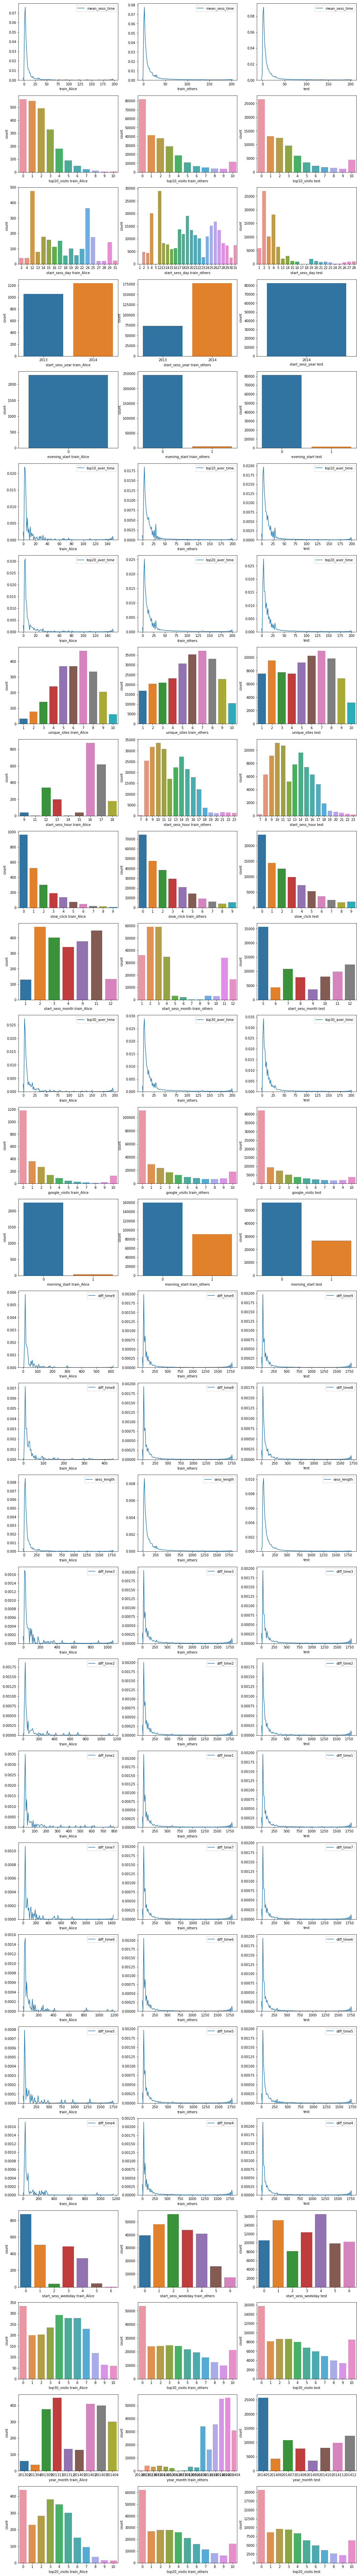

In [34]:
fig, axes = plt.subplots(nrows=len(features), ncols=3, figsize=(18, len(features)*5))

for idx in range(len(features)):
    if len(train_test_df[features[idx]].unique()) > 30:
        plt.subplot(len(features), 3, idx*3+1)
        ax = sns.kdeplot(train_fe[features[idx]][train_fe['target'] == 1])
        ax.set_xlabel('train_Alice') 

        plt.subplot(len(features), 3, idx*3+2)
        ax = sns.kdeplot(train_fe[features[idx]][train_fe['target'] == 0])
        ax.set_xlabel('train_others') 

        plt.subplot(len(features), 3, idx*3+3)
        ax = sns.kdeplot(test_fe[features[idx]])
        ax.set_xlabel('test')
    else:
        plt.subplot(len(features), 3, idx*3+1)
        ax = sns.countplot(train_fe[features[idx]][train_fe['target'] == 1])
        ax.set_xlabel(str(features[idx]) + ' train_Alice') 

        plt.subplot(len(features), 3, idx*3+2)
        ax = sns.countplot(train_fe[features[idx]][train_fe['target'] == 0])
        ax.set_xlabel(str(features[idx]) + ' train_others') 

        plt.subplot(len(features), 3, idx*3+3)
        ax = sns.countplot(test_fe[features[idx]])
        ax.set_xlabel(str(features[idx]) + ' test')

In [104]:
# выберем интересные в первом приближении признаки, разделим их на численные и категориальные
cat_features = [
 'start_sess_day',
 'start_sess_month',
 'start_sess_year',
 'start_sess_weekday',
 'evening_start',
 'year_month',
 'morning_start',
 'start_sess_hour'
 ]
num_features = [
 'mean_sess_time',
 'sess_length',
 'top10_visits',
 'top20_visits',
 'top30_visits',
 'top10_aver_time',
 'top20_aver_time',
 'top30_aver_time',
 'slow_click',
 'google_visits',
 'unique_sites'
]

In [110]:
# предобработка отобранных признаков, присоединение их к выборкам

# категориальные данные трансформируем one-hot-encoder`ом
ohe = OneHotEncoder()
X_train_test_cat_fe = ohe.fit_transform(train_test_df[cat_features])
X_train_cat_fe = X_train_test_cat_fe[:train_df.shape[0], :]
X_test_cat_fe = X_train_test_cat_fe[train_df.shape[0]:, :]

# числовые масштабируем
scaler = StandardScaler()
X_train_test_num_fe = scaler.fit_transform(train_test_df[num_features])
X_train_num_fe = X_train_test_num_fe[:train_df.shape[0], :]
X_test_num_fe = X_train_test_num_fe[train_df.shape[0]:, :]

# объединяем выборки
X_train_fe = hstack((X_train_cat_fe, X_train_num_fe))
X_test_fe = hstack((X_test_cat_fe, X_test_num_fe))

X_train_sparse_fe = hstack((X_train_sparse, X_train_fe, X_train_time_diff_sparse))
X_test_sparse_fe = hstack((X_test_sparse, X_test_fe, X_test_time_diff_sparse))

X_tr_fe = X_train_fe.toarray()[:train_share, :]
X_v_fe = X_train_fe.toarray()[train_share:, :]

X_train_fe = hstack((X_train, X_tr_fe, X_train_time_diff))
X_valid_fe = hstack((X_valid, X_v_fe, X_valid_time_diff))

# Построение модели

In [57]:
# выбранная стратегия кросс-валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [118]:
%%time
# Лучше всех себя в задаче показала логистическая регрессия, попробуем настроить коэффициент регуляризации
logit_c_values = np.logspace(-2, 1, 10)

logit_cv = LogisticRegressionCV(Cs=logit_c_values, random_state=42, n_jobs=-1, cv=skf, class_weight='balanced', scoring='roc_auc')
logit_cv.fit(X_train_sparse_fe, y)

Wall time: 11min 54s


(0.98858895897626464, 1.0)


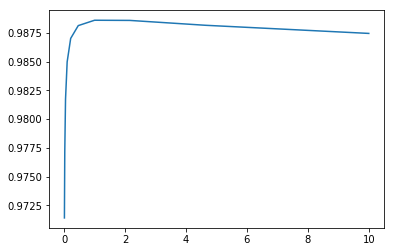

In [119]:
logit_mean_cv_scores = np.mean(np.mean(np.array(logit_cv.scores_.values()), axis=0), axis=0)
mean_cvs_and_cs = zip(logit_mean_cv_scores, logit_cv.Cs_)
mean_cvs_and_cs.sort(key=lambda x: x[0], reverse=True)
print(mean_cvs_and_cs[0])
plt.plot(logit_c_values, logit_mean_cv_scores)

In [121]:
logit = LogisticRegression(multi_class='ovr', random_state=42, n_jobs=-1, C=1.0, class_weight='balanced')
logit.fit(X_train_fe, y_train)
logit_valid_pred_proba = logit.predict_proba(X_valid_fe)[:, 1]
round(roc_auc_score(y_valid, logit_valid_pred_proba),5)

0.98728

Реально grid-search находит значение **C**, оптимальное на кроссвалидации, но на kaggle leaderboard лучшее значение дает другое значение.

Использование других моделей, подбор параметров, а также ансамблей этих моделей результат не улучшило.
Кроме того, необходим был вдумчивый отбор сгенерированных признаков, так как при использовании слишком большого их количества модель сильно переобучается.

In [80]:
# запишем полученный вариант в файл-submission
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [108]:
logit = LogisticRegression(multi_class='ovr', random_state=42, n_jobs=-1, class_weight='balanced')

logit.fit(X_train_sparse_fe, y)
logit_pred_prob_kaggle = logit.predict_proba(X_test_sparse_fe)[:, 1]
write_to_submission_file(logit_pred_prob_kaggle, 'final_submission.csv')

# Итоги

В данном проекте было предложено решить задачу идентификации одного конкретного пользователя из множества других посредством обработки информации о его сессиях в интернете.
Первоначально были предоставлены данные о сессиях пользователей, среди которых был выделен один - "Элис", его и необходимо было научиться идентифицировать. Задача свелась к классической задаче бинарной классификации с сильным дисбалансом классов.
Baseline-решения уже на начальных данных после tf-idf преобразования показали неплохие результаты на AUC-ROC.
После генерации дополнительных признаков, их отбора и подбора параметров поиском по сетке результат на public leaderboarde вошёл в топ-10%.

Полученная модель может быть использована для распознавания конкретного пользователя по его сессиям в интернете.

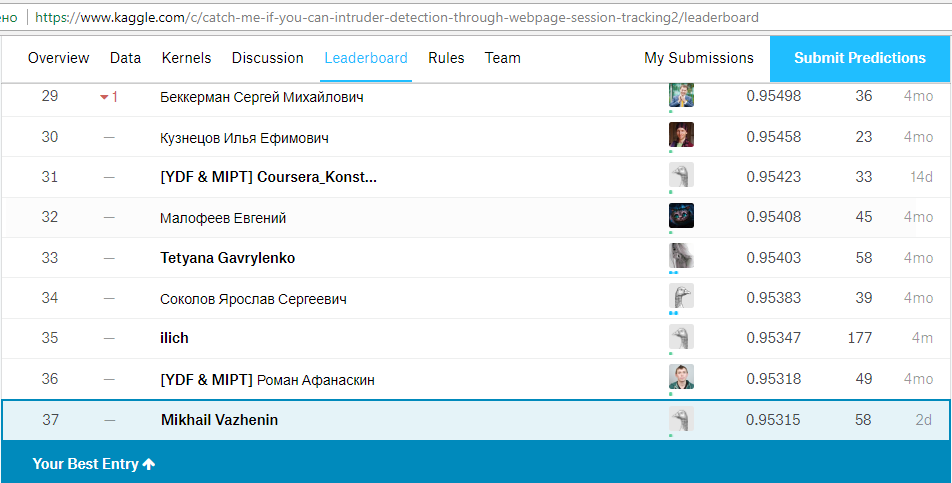